# HW8 - Transient Model With River 

Instructions:  
For this assignment we will all start from the self check model but each group will be responsible for doing a different modification. Note that you only have to do the part that is assigned to your group not all three parts.

Group 1:  
* Modify the self check example to make it a steady state model and then explore the sensitivity of the model to the boundary condition heads and the heads in the river (this would probably be best done with a loop).

* First systematically vary the two boundary condition heads. You can vary both heads together as well as create gradients across the domain by having one side be higher. Make sure you explore head ranges that make the aquifer confined and unconfined.

* Then explore changing the head in the river again systematically varying it across a range of values.

* Use the river leakage outputs in the water balance file to calculate how the water exchanges between the river and the aquifer change as a function of head

* Compare the impact of changing heads in the river to changing boundary condition heads on your results.

# Import Packages

In [ ]:
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
%matplotlib inline

In [ ]:
Lx=1000.
Ly=1000.
ztop=0.
zbot=-50.
nlay=1
nrow=25
ncol=25
dx=Lx/ncol
dy=Ly/nrow
dz=(ztop-zbot)/nlay
nper=1
steady=[True]
hk=1.
vka=1.
n=0.35
Sy=0.1
Ss=1e-4
ibound=np.ones((nlay,nrow,ncol),dtype=np.int32)
strt=np.ones((nlay,nrow,ncol),dtype=np.float32)

In [ ]:
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
for scenario in range(0,10):
    print('\n \n Scenario',scenario+1)
    modelname='Warlick_hw8'+'_SLR'+str(scenario+1)
    print(modelname)
    m=flopy.modflow.Modflow(modelname, exe_name=moddir)
    dis=flopy.modflow.ModflowDis(model=m,nlay=nlay,nrow=nrow,
                                 ncol=ncol,delr=dx,delc=dy,top=ztop,
                                 botm=zbot,itmuni=4,lenuni=2,nper=nper,
                                 steady=steady)
    
    bas=flopy.modflow.ModflowBas(m,ibound=ibound,strt=strt)
       
    lpf=flopy.modflow.ModflowLpf(m,laytyp=1,hk=hk,vka=vka,
                                 ss=Ss,sy=Sy,storagecoefficient=True,
                                 ipakcb=53)
    
    head=[-40,-30,-20,-10,0,10,20,30,40,50]
    bound_sp1=[]
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,head[scenario],head[scenario]])
            bound_sp1.append([lay,row,ncol-1,head[scenario],head[scenario]])
    chd_spd={0:bound_sp1}
    
    chd=flopy.modflow.ModflowChd(model=m,stress_period_data=chd_spd)

    riv_sp1=[]
    k_rivbott=1 
    sed_thick=1 
    cond=k_rivbott*(dy)*(dx)/(sed_thick) 
    r_stage=1 
    r_bott=0 
    for i in range(nrow):
        riv_sp1.append([0,i,ncol/2,r_stage,cond,r_bott])

    riv_spd={0:riv_sp1}

    riv=flopy.modflow.ModflowRiv(model=m,stress_period_data=riv_spd,ipakcb=53)

    pcg=flopy.modflow.ModflowPcg(model=m)
    
    spd={(0,0):['print head','print budget','save head', 
                'save budget']}  
    
    oc=flopy.modflow.ModflowOc(m,stress_period_data=spd,compact=True)

    m.write_input()
    success,mfoutput=m.run_model(pause=False,report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')


# Read Head Files

In [ ]:
head={}
frf={}
fff={}
consthead={}
leakage={}
for read in range(0,10):
    modelname='Warlick_hw8'+'_SLR'+str(read+1)
    headobj=flopy.utils.binaryfile.HeadFile(modelname+'.hds')
    budgobj=flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
    times=headobj.get_times()  
    head['run%s'%(read)]=headobj.get_data(totim=times[0])  
    frf['run%s'%(read)]=budgobj.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fff['run%s'%(read)]=budgobj.get_data(text='FLOW FRONT FACE',totim=1.0) 
    consthead['run%s'%(read)]=budgobj.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakage['run%s'%(read)]=budgobj.get_data(text='RIVER LEAKAGE',totim=1.0)

In [ ]:
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)

#create a figure for every time
for scenario in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(head['run%s'%(scenario)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Head Surface: SLR %s'%(scenario+1), fontsize=15, fontweight='bold')
    plt.show(surf)

In [ ]:
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
for scenario in range(0,10):
    print('\n \n Scenario',scenario+1)
    modelnameL='Warlick_hw8'+'_SL'+str(scenario+1)
    print(modelnameL)
    m=flopy.modflow.Modflow(modelnameL, exe_name=moddir)
    dis=flopy.modflow.ModflowDis(model=m,nlay=nlay,nrow=nrow,
                                 ncol=ncol,delr=dx,delc=dy,top=ztop,
                                 botm=zbot,itmuni=4,lenuni=2,nper=nper,
                                 steady=steady)
    
    bas=flopy.modflow.ModflowBas(m,ibound=ibound,strt=strt)
       
    lpf=flopy.modflow.ModflowLpf(m,laytyp=1,hk=hk,vka=vka,
                                 ss=Ss,sy=Sy,storagecoefficient=True,
                                 ipakcb=53)
    
    headL=[-40,-30,-20,-10,0,10,20,30,40,50]
    headR=[-40]
    bound_sp1=[]
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,headL[scenario],headL[scenario]])
            bound_sp1.append([lay,row,ncol-1,headR[0],headR[0]])
    chd_spd={0:bound_sp1}
    
    chd=flopy.modflow.ModflowChd(model=m,stress_period_data=chd_spd)

    riv_sp1=[]
    k_rivbott=1 
    sed_thick=1 
    cond=k_rivbott*(dy)*(dx)/(sed_thick) 
    r_stage=1 
    r_bott=0 
    for i in range(nrow):
        riv_sp1.append([0,i,ncol/2,r_stage,cond,r_bott])

    riv_spd={0:riv_sp1}

    riv=flopy.modflow.ModflowRiv(model=m,stress_period_data=riv_spd,ipakcb=53)

    pcg=flopy.modflow.ModflowPcg(model=m)
    
    spd={(0,0):['print head','print budget','save head', 
                'save budget']}  
    
    oc=flopy.modflow.ModflowOc(m,stress_period_data=spd,compact=True)

    m.write_input()
    success,mfoutput=m.run_model(pause=False,report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')


In [ ]:
headL={}
frfL={}
fffL={}
constheadL={}
leakageL={}
for read in range(0,10):
    modelnameL='Warlick_hw8'+'_SL'+str(read+1)
    headobjL=flopy.utils.binaryfile.HeadFile(modelnameL+'.hds')
    budgobjL=flopy.utils.binaryfile.CellBudgetFile(modelnameL+'.cbc')
    times=headobjL.get_times()  
    headL['run%s'%(read)]=headobjL.get_data(totim=times[0])  
    frfL['run%s'%(read)]=budgobjL.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fffL['run%s'%(read)]=budgobjL.get_data(text='FLOW FRONT FACE',totim=1.0) 
    constheadL['run%s'%(read)]=budgobjL.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakageL['run%s'%(read)]=budgobjL.get_data(text='RIVER LEAKAGE',totim=1.0)

In [ ]:
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
for i in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(headL['run%s'%(i)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Head Surface: SL %s'%(i+1), fontsize=15, fontweight='bold')
    plt.show(surf)

In [ ]:
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
for scenario in range(0,10):
    print('\n \n Scenario',scenario+1)
    modelnameR='Warlick_hw8'+'_SR'+str(scenario+1)
    print(modelnameR)
    m=flopy.modflow.Modflow(modelnameR, exe_name=moddir)
    dis=flopy.modflow.ModflowDis(model=m,nlay=nlay,nrow=nrow,
                                 ncol=ncol,delr=dx,delc=dy,top=ztop,
                                 botm=zbot,itmuni=4,lenuni=2,nper=nper,
                                 steady=steady)
    
    bas=flopy.modflow.ModflowBas(m,ibound=ibound,strt=strt)
       
    lpf=flopy.modflow.ModflowLpf(m,laytyp=1,hk=hk,vka=vka,
                                 ss=Ss,sy=Sy,storagecoefficient=True,
                                 ipakcb=53)
    
    headR=[-40,-30,-20,-10,0,10,20,30,40,50]
    headL=[-40]
    bound_sp1=[]
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,headL[0],headL[0]])
            bound_sp1.append([lay,row,ncol-1,headR[scenario],headR[scenario]])
    chd_spd={0:bound_sp1}
    
    chd=flopy.modflow.ModflowChd(model=m,stress_period_data=chd_spd)

    riv_sp1=[]
    k_rivbott=1 
    sed_thick=1 
    cond=k_rivbott*(dy)*(dx)/(sed_thick) 
    r_stage=1 
    r_bott=0 
    for i in range(nrow):
        riv_sp1.append([0,i,ncol/2,r_stage,cond,r_bott])

    riv_spd={0:riv_sp1}

    riv=flopy.modflow.ModflowRiv(model=m,stress_period_data=riv_spd,ipakcb=53)

    pcg=flopy.modflow.ModflowPcg(model=m)
    
    spd={(0,0):['print head','print budget','save head', 
                'save budget']}  
    
    oc=flopy.modflow.ModflowOc(m,stress_period_data=spd,compact=True)

    m.write_input()
    success,mfoutput=m.run_model(pause=False,report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')


In [ ]:
headR={}
frfR={}
fffR={}
constheadR={}
leakageR={}
for read in range(0,10):
    modelnameR='Warlick_hw8'+'_SR'+str(read+1)
    headobjR=flopy.utils.binaryfile.HeadFile(modelnameR+'.hds')
    budgobjR=flopy.utils.binaryfile.CellBudgetFile(modelnameR+'.cbc')
    times=headobjR.get_times()  
    headR['run%s'%(read)]=headobjR.get_data(totim=times[0])  
    frfR['run%s'%(read)]=budgobjR.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fffR['run%s'%(read)]=budgobjR.get_data(text='FLOW FRONT FACE',totim=1.0) 
    constheadR['run%s'%(read)]=budgobjR.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakageR['run%s'%(read)]=budgobjR.get_data(text='RIVER LEAKAGE',totim=1.0)

In [ ]:
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
for i in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(headR['run%s'%(i)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Head Surface: SR %s'%(i+1), fontsize=15, fontweight='bold')
    plt.show(surf)

In [127]:
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
for scenario in range(0,10):
    print('\n \n Scenario',scenario+1)
    modelnameRiver='Warlick_hw8'+'_SRiver'+str(scenario+1)
    print(modelnameRiver)
    m=flopy.modflow.Modflow(modelnameRiver, exe_name=moddir)
    dis=flopy.modflow.ModflowDis(model=m,nlay=nlay,nrow=nrow,
                                 ncol=ncol,delr=dx,delc=dy,top=ztop,
                                 botm=zbot,itmuni=4,lenuni=2,nper=nper,
                                 steady=steady)
    
    bas=flopy.modflow.ModflowBas(m,ibound=ibound,strt=strt)
       
    lpf=flopy.modflow.ModflowLpf(m,laytyp=1,hk=hk,vka=vka,
                                 ss=Ss,sy=Sy,storagecoefficient=True,
                                 ipakcb=53)
    
    head=[-30]
    bound_sp1=[]
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,head[0],head[0]])
            bound_sp1.append([lay,row,ncol-1,head[0],head[0]])
    chd_spd={0:bound_sp1}
    
    chd=flopy.modflow.ModflowChd(model=m,stress_period_data=chd_spd)

    riv_sp1=[]
    k_rivbott=1 
    sed_thick=1 
    cond=k_rivbott*(dy)*(dx)/(sed_thick) 
    r_stage=[0,1,2,3,4,5,6,7,8,9]
    r_bott=0 
    for i in range(nrow):
        riv_sp1.append([0,i,ncol/2,r_stage[scenario],cond,r_bott])

    riv_spd={0:riv_sp1}

    riv=flopy.modflow.ModflowRiv(model=m,stress_period_data=riv_spd,ipakcb=53)

    pcg=flopy.modflow.ModflowPcg(model=m)
    
    spd={(0,0):['print head','print budget','save head', 
                'save budget']}  
    
    oc=flopy.modflow.ModflowOc(m,stress_period_data=spd,compact=True)

    m.write_input()
    success,mfoutput=m.run_model(pause=False,report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')



 
 Scenario 1
Warlick_hw8_SRiver1
FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Warlick_hw8_SRiver1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/08 20:34:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/08 20:34:13
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation

 
 Scenario 2
Warlick_hw8_SRiver2
FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                 

In [128]:
headRiver={}
frfRiver={}
fffRiver={}
constheadRiver={}
leakageRiver={}
for read in range(0,10):
    modelnameRiver='Warlick_hw8'+'_SRiver'+str(read+1)
    headobjRiver=flopy.utils.binaryfile.HeadFile(modelnameRiver+'.hds')
    budgobjRiver=flopy.utils.binaryfile.CellBudgetFile(modelnameRiver+'.cbc')
    times=headobjRiver.get_times()  
    headRiver['run%s'%(read)]=headobjRiver.get_data(totim=times[0])  
    frfRiver['run%s'%(read)]=budgobjRiver.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fffRiver['run%s'%(read)]=budgobjRiver.get_data(text='FLOW FRONT FACE',totim=1.0) 
    constheadRiver['run%s'%(read)]=budgobjRiver.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakageRiver['run%s'%(read)]=budgobjRiver.get_data(text='RIVER LEAKAGE',totim=1.0)

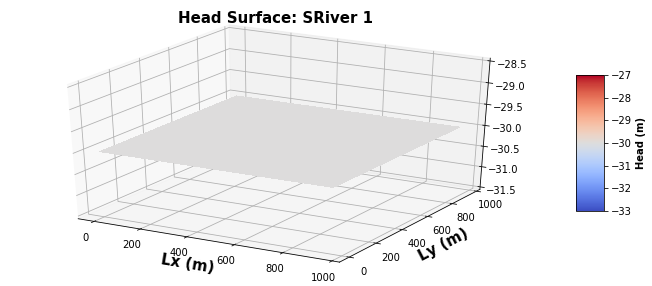

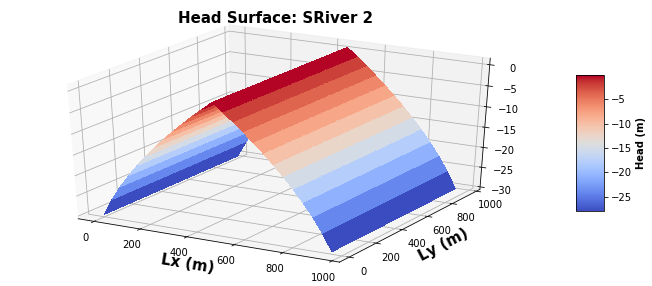

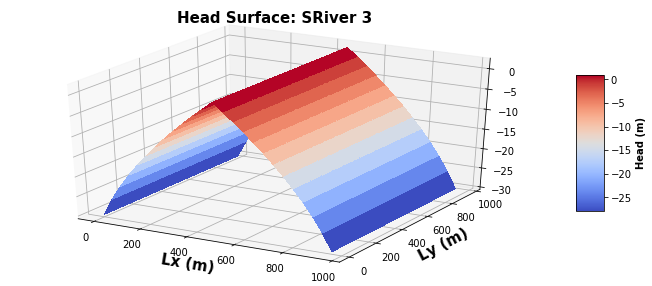

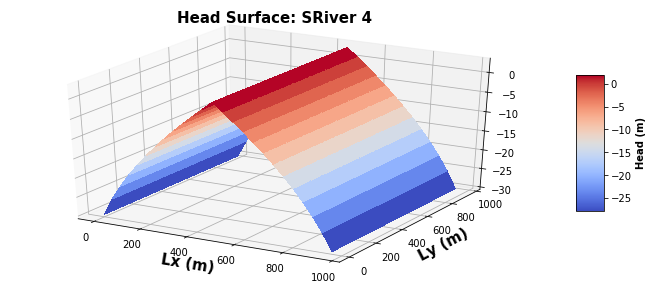

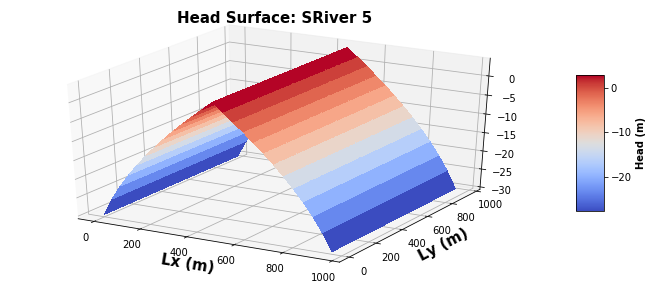

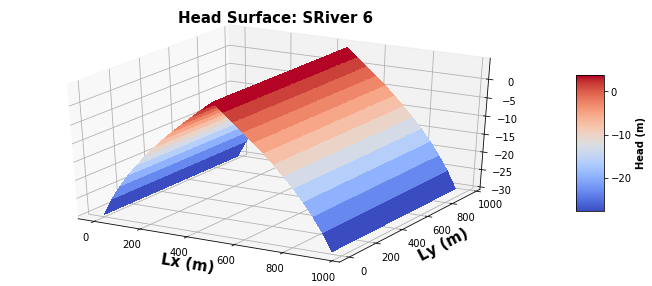

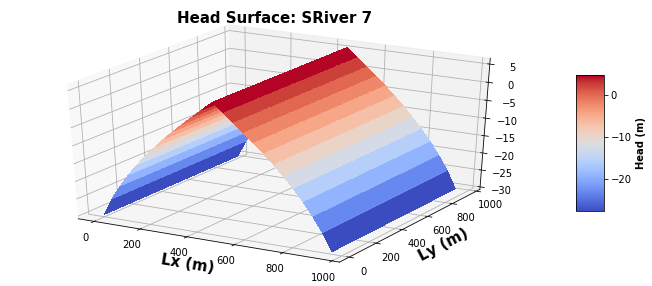

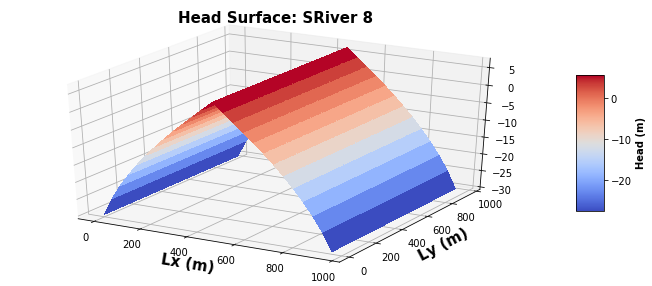

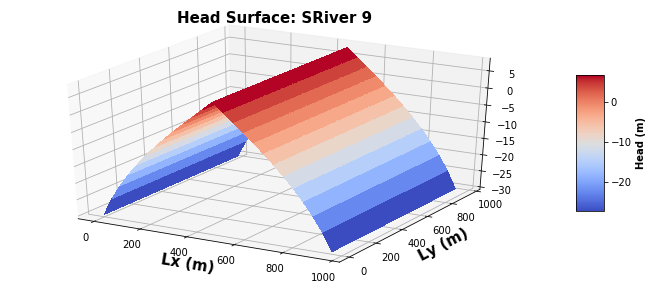

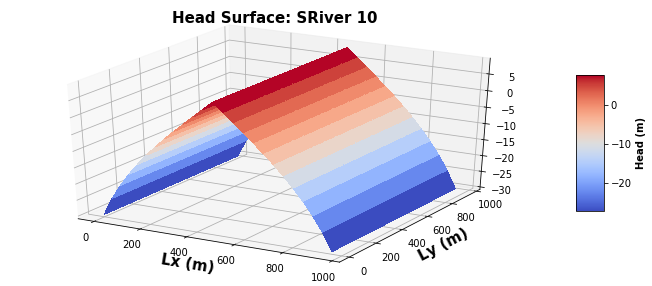

In [129]:
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
for i in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(headRiver['run%s'%(i)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Head Surface: SRiver %s'%(i+1), fontsize=15, fontweight='bold')
    plt.show(surf)